In [1]:
from pyspark.sql import SparkSession
from urllib.request import urlretrieve
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)  
    .config("spark.executor.memory","4G")
    .config("spark.driver.memory","8G")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 01:57:10 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.17.1.121 instead (on interface eth0)
22/08/22 01:57:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 01:57:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.conf.set("spark.sql.parquet.compression.codec", "gzip")

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import scipy as sp

In [4]:
FEATURES = ['PULocationID', 'trip_distance', 'fare_amount', 'average_speed', 'time_duration', \
   'Temperature (F)', 'Wind Speed (mph)', 'Pickup_Time', 'Is_Airport', 'Is_Weekend', 'Is_Rainy']
features = 'features'

In [5]:
# vectorise the features that are going to be put into the model
def feature_converter(sdf):
    vecAss = VectorAssembler(
    # features to be used
    inputCols=FEATURES, 
    # name of the output column
    outputCol=features
    )
    df_va = vecAss.transform(sdf)
    return df_va

In [6]:
# act as a pipline before modeling
def preparation(sdf):
    # vectorisation
    sdf = feature_converter(sdf)
    # take only the feature vector and the response
    sdf = sdf.select([features, 'tip_amount'])
    return sdf
    

In [7]:
# read in the train test dataframe
train_sdf = spark.read.parquet('../data/curated/tlc_data/Model_data.parquet')
test_sdf = spark.read.parquet('../data/curated/tlc_data/Test_data.parquet')
# pipline the dataframes
train_sdf = preparation(train_sdf)
test_sdf = preparation(test_sdf)
# set up the RFR model
rf = RandomForestRegressor(numTrees = 10, maxDepth = 10, labelCol='tip_amount')
model = rf.fit(train_sdf)
result = model.transform(test_sdf)
# evaluate the model result based on mae and mse
rf_evaluator = RegressionEvaluator(labelCol='tip_amount', metricName="mae", predictionCol='prediction')
mae = rf_evaluator.evaluate(result)
rf_evaluator = RegressionEvaluator(labelCol='tip_amount', metricName="mse", predictionCol='prediction')
mse = rf_evaluator.evaluate(result)
print('+++++++++++++++++++++++++++++++++++++++++++')
print(f'Using Categorical feature: {FEATURES}')
print('mae:{}'.format(mae))
print('mse:{}'.format(mse))


22/08/22 01:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1806.2 KiB


+++++++++++++++++++++++++++++++++++++++++++
Using Categorical feature: ['PULocationID', 'trip_distance', 'fare_amount', 'average_speed', 'time_duration', 'Temperature (F)', 'Wind Speed (mph)', 'Pickup_Time', 'Is_Airport', 'Is_Weekend', 'Is_Rainy']
mae:0.5335386016978068
mse:0.6042790612360339


In [8]:
result.select(F.col('tip_amount') - F.col('prediction')).describe()

summary,(tip_amount - prediction)
count,1859987
mean,0.040271992141957015
stddev,0.7763102162774379
min,-4.246570163910771
max,4.205865965731269


In [9]:
plot = result.toPandas()

In [10]:
plot['residual'] = plot['prediction'] - plot['tip_amount']

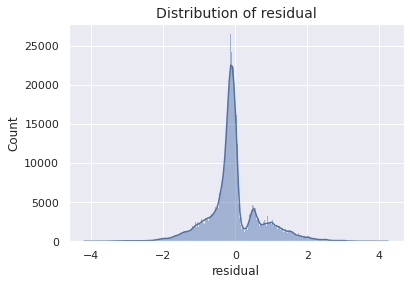

In [12]:
# Plots the distribution of Residuals
sbs.set_theme(style = 'darkgrid')
sbs.histplot(plot['residual'], kde = True)
plt.title('Distribution of residual', size = 14)
# save the figure
plt.savefig('../plots/Distribution of residual')
plt.show()

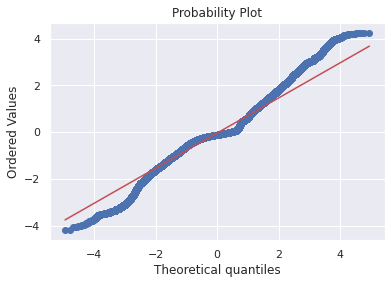

In [13]:
# Plots the QQ plot
fig, ax = plt.subplots()
sp.stats.probplot(plot['residual'], plot=ax, fit=True)
# save the figure
plt.savefig('../plots/QQ plot')
plt.show()